In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

#QCD
b0 = 2./9.
Lambda2 = 0.2**2
NC = 3.
CA = np.copy(NC)
CF = (NC**2-1)/(2.*NC)
TR = 1./2.

# Runge-Kuta-4 for ODE sets
def RK4(t, y, dydt, dt):
    k1 = dydt(t, y)
    k2 = dydt(t+dt/2., y+dt/2.*k1)
    k3 = dydt(t+dt/2., y+dt/2.*k2)
    k4 = dydt(t+dt, y+dt*k3)
    dy = dt/6. * (k1 + k2*2. + k3*2. + k4)
    return y+dy


# Grid
lnxgrid = np.linspace(np.log(1e-3),np.log(.999),210)
xgrid = np.exp(lnxgrid)
#dx = xgrid[1]-xgrid[0]
dlnx = lnxgrid[1]-lnxgrid[0]


In [41]:
# Scheme-1
# Pqq
def Rqq(x, kt2):
    return CF*(1+x**2) 
def Dqq(kt2):
    return CF*3./2.
# Pqg
def Pqg(x, kt2):
    return CF * (1+(1-x)**2)/x 
# Pgg
def Rgg(x, kt2):
    return 2*CA*x
def Agg(x, kt2):
    return 2*CA* ( (1-x)/x + x*(1-x) )
def Dgg(kt2, nf):
    return 2*CA*  ( 11/12. - nf/18. )
# Pqg
def Pgq(x, kt2):
    return TR*(x**2+(1-x)**2)

# PQQ
@np.vectorize
def RQQ(x, kt2, m2):
    return CF*(1+x**2)

@np.vectorize
def AQQ(x, kt2, m2):
    if (kt2<0):
        return 0
    return - CF*2*x*(1-x)/(kt2/m2+(1-x)**2)

@np.vectorize
def DQQ(kt2_m2, xmin):
    if (kt2_m2<0):
        return 0
    kt_m = np.sqrt(kt2_m2)
    return CF*( 1-xmin + .5*(1-xmin**2)
            + np.log((kt2_m2+(1-xmin)**2)/kt2_m2) 
            + 2*kt_m*np.arctan((1-xmin)/kt_m) - 2. + 2.*xmin
              )


In [44]:
# scheme-1 R(x)/[(1-x)]_+

# q - qbar
def dzD_valance_dt_1(t, zD):
    kt2 = xgrid*(1-xgrid) * Lambda2 * np.exp(np.exp(t/b0))
    
    N = zD.size
    dydt = np.zeros_like(zD)
    Rgrids = Rqq(xgrid, kt2)
    zover1mz = xgrid/(1-xgrid+1e-15)
    for i in range(N):
        
        x = xgrid[i]
        S1 = 0.0
        for j in range(i,N):
            S1 += (zD[N-1-j+i]*Rgrids[j] - zD[i]*Rgrids[N-1]) * zover1mz[j] * dlnx
        dydt[i] += S1
        
        S2 = 0.0
        for j in range(i):
            S2 +=  zover1mz[j] * dlnx
        dydt[i] -= S2 * zD[i]*Rgrids[N-1]
    
        dydt[i] += Dqq(t)*zD[i]
    return dydt


# g,q+qbar
def dzD_singlet_dt_1(t, zD, Nf=3):
    kt2 = xgrid*(1-xgrid) * Lambda2 * np.exp(np.exp(t/b0))
    zG, zQ = zD
    N = zG.size
    dydt = np.zeros_like(zD)
    zover1mz = xgrid/(1-xgrid+1e-15)
    
    # Gluon part
    Rgrids = Rgg(xgrid, kt2)
    Agrids = Agg(xgrid, kt2)
    Pgrids = Pgq(xgrid, kt2)
    for i in range(N):
        x = xgrid[i]
        # From g->g
        S1 = 0.0
        for j in range(i,N-1):
            S1 += (zG[N-1-j+i]*Rgrids[j] - zG[i]*Rgrids[N-1]) * zover1mz[j]
        dydt[0,i] += S1 * dlnx
        S2 = 0.0
        for j in range(i):
            S2 +=  zover1mz[j]
        dydt[0,i] -= S2 * dlnx * zG[i]*Rgrids[N-1]
        for j in range(i,N):
            dydt[0,i] += zG[N-1-j+i]*Agrids[j]*xgrid[j] * dlnx
        dydt[0,i] += Dgg(t,Nf)*zG[i]
        # From g -> q + qbar
        for j in range(i,N):
            dydt[0,i] += 1./Nf*zQ[N-1-j+i]*Pgrids[j]*xgrid[j] * dlnx
          
    # q+qbar part
    Rgrids = Rqq(xgrid, kt2)
    Pgrids = Pqg(xgrid, kt2)
    for i in range(N):        
        S1 = 0.0
        for j in range(i,N-1):
            S1 += (zQ[N-1-j+i]*Rgrids[j] - zQ[i]*Rgrids[N-1]) * zover1mz[j]
        dydt[1,i] += S1 * dlnx
        S2 = 0.0
        for j in range(i):
            S2 +=  zover1mz[j]
        dydt[1,i] -= S2 * dlnx * zQ[i]*Rgrids[N-1]
        dydt[1,i] += Dqq(t)*zG[i]
        # From q+qbar -> g
        for j in range(i,N):
            dydt[1,i] += Nf * zG[N-1-j+i]*Pgrids[j]*xgrid[j] * dlnx
            

    return dydt

[]

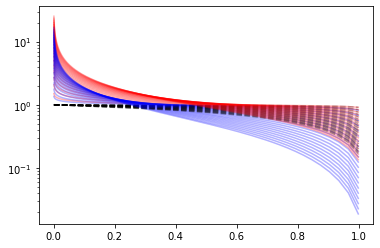

In [45]:
# Exact solution in the soft gluon limit
lambdaz = 0.0
nz = lambdaz+1
def quenching(z,t,t0):
    return np.exp(-2*CF*(t-t0) * (lambdaz*(1-z)-np.log(1-z+1e-9)) )
# Numerics
zDv = 1/xgrid**lambdaz
zDs = np.array([zDv, zDv])

Q2min = 1**2
Q2max = 10**2
tmin = b0*np.log(np.log(Q2min/Lambda2))
tmax = b0*np.log(np.log(Q2max/Lambda2))
Nt = 21
dt = (tmax-tmin)/(Nt-1)
t = tmin

for i in range(Nt):
    zDv = RK4(t, zDv, dzD_valance_dt_1, dt)
    plt.plot(xgrid, zDv, 'k--', alpha=.3)

    zDs = RK4(t, zDs, dzD_singlet_dt_1, dt)
    plt.plot(xgrid, zDs[0], 'b-', alpha=.3)
    plt.plot(xgrid, zDs[1], 'r-', alpha=.3)

    t+=dt

plt.semilogy()

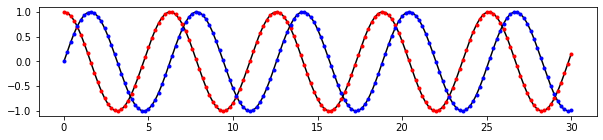

In [8]:
# test RK4 
plt.figure(figsize=(10,2))
t = np.linspace(0,30,10000)
ytruth = np.array([np.cos(t), np.sin(t)]).T
plt.plot(t, ytruth, 'k-')

def dydt(t, y):
    return np.array([-y[1], y[0]])
t = 0
dt = .2
y = ytruth[0]
while t < 30:
    plt.plot(t, y[0], 'r.')
    plt.plot(t, y[1], 'b.')
    y = RK4(t, y, dydt, dt)
    t+=dt

In [9]:
# scheme-2 [R/(1-x)]_+

# q-qbar
def dzDvdt_2(t, zD):
    kt2 = xgrid*(1-xgrid) * Lambda2 * np.exp(np.exp(t/b0))
    N = zD.size
    dydt = np.zeros(N)
    
    Rgrids = Rqq(xgrid, kt2)
    zover1mz = xgrid/(1-xgrid+1e-15)
    for i in range(N):
        
        x = xgrid[i]
        A = 0.0
        for j in range(i,N-1):
            A += (zD[N-1-j+i] - zD[i]) * zover1mz[j] * dlnx *Rgrids[j]
        dydt[i] += A
        
        B = 0.0
        for j in range(i):
            B +=  zover1mz[j] * dlnx * Rgrids[j]
        dydt[i] -= B * zD[i]
    
    return dydt